## Brief desciption of the problem and data
For this assignment, we are provided with a large number of tweets. We are tasked with predicting whether a given tweet is about a real disaster or not. Our training data consists of 7.613 tweets with labels. If the tweet is about a distaster, the data is labeled "positive" (1) otherwise, the data is labeled "negative" (0). There are no missing data for the text itself, but there are some missing data for the location from which the tweet was sent, and the keywords associated with the tweet.

## Downloading the datasets from the Kaggle website and loading into train/test
We'll start by downloading the datasets from the kaggle website. We have a training set, a test set (to make predictions on), and a sample submission set.

In [1]:
# Import the packages for downloading Kaggle datasets
import opendatasets as od

# Download the histopathologic cancer detection dataset from Kaggle using opendatasets.
od.download("https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv")

Skipping, found downloaded files in "./nlp-getting-started" (use force=True to force download)


Then, let's load all the datasets into the appropriate variables. I'll also add a variable to indicate the lengths of the various texts as 'text_len'

In [2]:
import pandas as pd

train_df = pd.read_csv("nlp-getting-started/train.csv")
test_df = pd.read_csv("nlp-getting-started/test.csv")
sample_sub = pd.read_csv("nlp-getting-started/sample_submission.csv")

train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))
test_df['text_len'] = test_df['text'].apply(lambda x: len(x.split(' ')))

train_df.head()

,id,keyword,location,text,target,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17


## Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data
Let's start of by taking a look at the complete training set. The histogram below shows the distribution of the Real/Fake labels. We can see that about 43% of the data is labeled as "Real" (1), while 57% is labeled as "Fake" (0). The "Real" tweets address disasters, while the others don't.

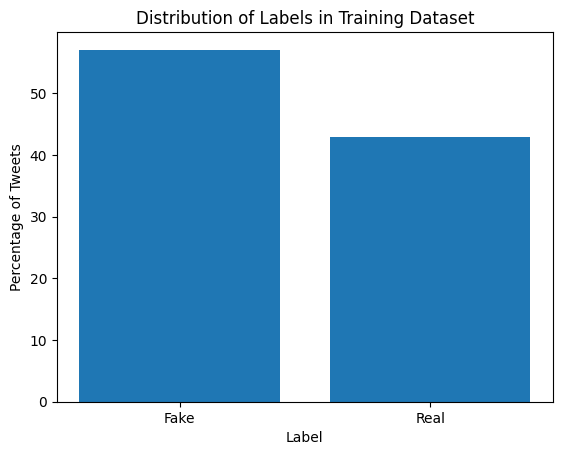

In [3]:
import matplotlib.pyplot as plt

# Count the number of images with each label
label_counts = train_df["target"].value_counts()

# Calculate the label distribution as a percentage
label_percentages = label_counts / label_counts.sum() * 100

# Create a bar chart showing the label distribution
plt.bar(label_percentages.index, label_percentages.values)
plt.xticks([0, 1], ["Fake", "Real"])
plt.xlabel("Label")
plt.ylabel("Percentage of Tweets")
plt.title("Distribution of Labels in Training Dataset")
plt.show()

Fortunately, the data does not need much cleaning. Since the groups are rougly balanced, we don't need sophisticated stratification techniques to adjust imbalances. 

Additionally, let's look at the distribution of the length of all the tweets, and the location from which they were tweeted.

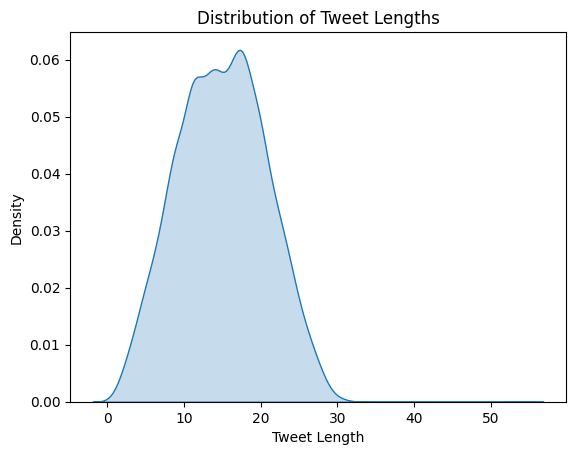

In [4]:
import seaborn as sns

# Create a density plot of tweet lengths
sns.kdeplot(train_df['text_len'], fill=True)
plt.xlabel('Tweet Length')
plt.ylabel('Density')
plt.title('Distribution of Tweet Lengths')
plt.show()

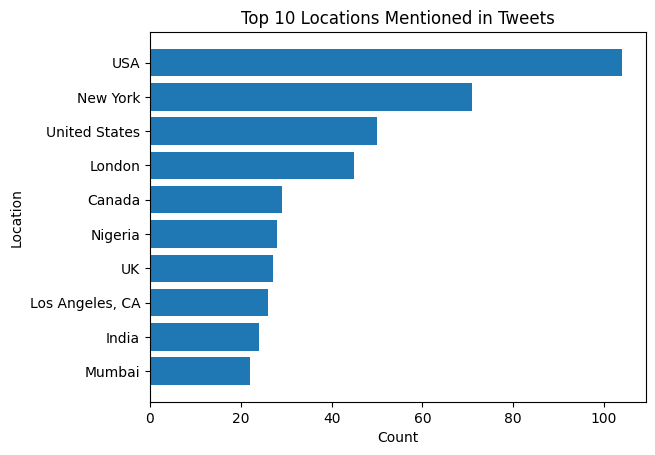

In [5]:
# Get the top 10 locations mentioned in the "location" column
top_locations = train_df['location'].value_counts().nlargest(10)

# Create a horizontal bar chart of the top 10 locations
fig, ax = plt.subplots()
ax.barh(top_locations.index, top_locations.values)
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_ylabel('Location')
ax.set_title('Top 10 Locations Mentioned in Tweets')
plt.show()

We can see that most of the tweets are about 10 to 20 words long. Most of them are tweeted from the United States. Interestingly, the location data can be denoted in various ways (city, state, country). USA, New York, United States, and Los Angeles, CA could also have been gathered into one variable. If we are using this in the analysis, we should consider such a cleaning step.

Finally, lets look at the number of images in both the training and external test data.

In [6]:
# Count the number of tweets in the sets
num_test_images = len(test_df)
num_train_images = len(train_df)

# Print the number of tweets in each dataset
print('No. of tweets in training dataset:', num_train_images)
print('No. of tweets in testing dataset:', num_test_images)

No. of tweets in training dataset: 7613
No. of tweets in testing dataset: 3263


We have 7613 tweets in the training dataset, which we still need to split in a true training set and an internal validation set, and then we have 3263 tweets in the test set, which we need to predict.

## Data Preprocessing
Now that we have inspected the data, we can start cleaning it. First, let's prepare the data for text analysis. In the code below, we will remove stopwords (which have no meaning), do word stemming, remove punctuations and emojis, and make it all into lower case.

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Define regular expressions for cleaning text
url_regex = re.compile(r'https?://\S+|www\.\S+')  # Matches URLs starting with http/https or www
html_regex = re.compile(r'<.*?>')  # Matches HTML tags
punctuation_regex = re.compile('[%s]' % re.escape(string.punctuation))  # Matches punctuation marks
digit_regex = re.compile('\w*\d\w*')  # Matches digits
emoji_regex = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+', flags=re.UNICODE)  # Matches emojis

# Combine stopwords with additional words to exclude
stop_words = set(stopwords.words('english')) | set(['u', 'im', 'c'])

# Initialize stemmer for word stemming
stemmer = nltk.SnowballStemmer("english")

def clean_text(text):
    '''Clean the input text by performing the following steps:
       - Convert text to lowercase
       - Remove text in square brackets
       - Remove URLs
       - Remove HTML tags
       - Remove punctuation marks
       - Remove words containing digits
       - Remove emojis
       - Remove stopwords
       - Stem remaining words
    '''
    # Convert text to lowercase
    text = str(text).lower()
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove URLs
    text = url_regex.sub('', text)
    # Remove HTML tags
    text = html_regex.sub('', text)
    # Remove punctuation marks
    text = punctuation_regex.sub('', text)
    # Remove words containing digits
    text = digit_regex.sub('', text)
    # Remove emojis
    text = emoji_regex.sub('', text)
    # Remove stopwords and stem remaining words
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

In [8]:
train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

train_df.head()

,id,keyword,location,text,target,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


The table above shows a column with the cleaned text. We can use these cleaned texts to create a wordcloud and see what kind of words are in real disaster tweets, and which are in fake disaster tweets:

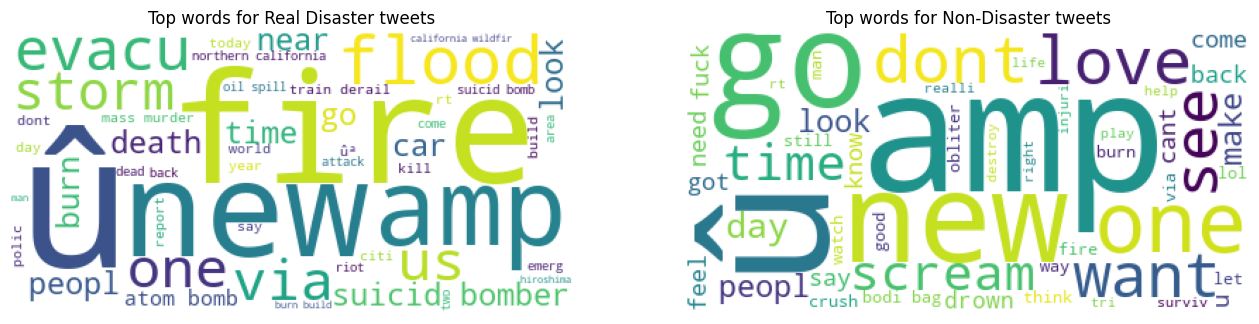

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

# Generate WordCloud for Real disaster tweets
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in train_df.loc[train_df['target'] == 1, 'text_clean']))

# Generate WordCloud for Fake disaster tweets
wc1 = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc1.generate(' '.join(text for text in train_df.loc[train_df['target'] == 0, 'text_clean']))

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Top words for Real Disaster tweets')
plt.imshow(wc)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title('Top words for Non-Disaster tweets')
plt.imshow(wc1)
plt.axis("off")
plt.show()


Now that the text is cleaned, we can proceed with tokenizing and vectorizing the text. Tokenization is the process of breaking up text into individual words or tokens. We can use the Tokenizer function in tensorflow for this.

In [10]:
train_tweets = train_df['text_clean'].values
train_target = train_df['target'].values
test_tweets = test_df['text_clean'].values

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)
vocab_length = len(word_tokenizer.word_index) + 1

Next, we are ready to convert the text data into sequences of integers and pad those sequences with zeros so that all sequences have the same length as the longest sentence in the training data.

In [12]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.utils import pad_sequences

def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3661,  457,  205, ...,    0,    0,    0],
       [ 140,    2,  107, ...,    0,    0,    0],
       [1346,  512, 1821, ...,    0,    0,    0],
       ...,
       [ 454, 1335,    0, ...,    0,    0,    0],
       [  28,  165, 2651, ...,    0,    0,    0],
       [ 174,   30,  420, ...,    0,    0,    0]], dtype=int32)

Next, we need create an embeddings weight matrix to initialize the embedding layer in the neural network. Specifically, the code initializes an empty embedding matrix with dimensions (vocab_length, embedding_dim), where vocab_length is the size of the vocabulary and embedding_dim is the dimension of the pre-trained GloVe word vectors which we have downloaded from their website.

The code then iterates over each word in the vocabulary and checks if it is present in the pre-trained GloVe embeddings dictionary. If it is, the corresponding embedding vector is added to the embedding matrix at the index corresponding to the word's position in the vocabulary. If it is not present in the pre-trained embeddings dictionary, the corresponding row in the embedding matrix is left as zeros.

In [37]:
embeddings_dictionary = dict()
embedding_dim = 300
glove_file = open('glove.6B.300d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Finally, we create a training and validation set from the full training set, using an 80/20 train test split. We don't need to stratify based on outcomes, since they are roughly balanced.

In [14]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.20
)

## Model Architecture
Now we can set up a model architecture and train it. The model below consists of an Embedding layer followed by two LSTM layers and a Dense layer with a sigmoid activation function. The Embedding layer maps each word in the input sentences to a high-dimensional vector representation. In this case, we have used te GloVe method. The two LSTM layers allow the model to capture the temporal dependencies and long-term dependencies between words in the input sentences. The first LSTM layer has the return sequences parameter set to True, which means that it returns the full sequence of hidden state outputs for each time step in the input sequence. The second LSTM layer takes the final hidden state output from the first LSTM layer as input and returns a single hidden state output. Finally, the Dense layer with sigmoid activation function produces a single output value for each input sentence, representing the probability that the sentence expresses a real disaster tweet.

This architecture is suitable for sentiment analysis because it is able to capture the sequential nature of language and the dependencies between words in the input sentences. The LSTM layers are particularly effective at handling long-term dependencies. 

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define model hyperparameters
embedding_dim = 300
lstm_units = 64
dropout_rate = 0.2
batch_size = 64
epochs = 15

# Define the model architecture
model = Sequential([
    Embedding(input_dim=vocab_length, output_dim=embedding_dim, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False),
    LSTM(units=lstm_units, dropout=dropout_rate, return_sequences=True), # Add an LSTM layer with return sequences set to True
    LSTM(units=lstm_units, dropout=dropout_rate), # Add another LSTM layer
    Dense(units=1, activation='sigmoid') # Add a final dense layer with sigmoid activation function
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler to reduce learning rate if val_loss doesn't improve for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=5,                        
    min_lr=0.001
)

# Add checkpoints to save the model with the best val_loss
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True
)

# Fit the model
history = model.fit(train_padded_sentences, 
                    train_target, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test), 
                    verbose=2, 
                    callbacks=[reduce_lr, checkpoint])


Epoch 1/15

Epoch 1: val_loss improved from inf to 0.45657, saving model to model.h5
119/119 - 5s - loss: 0.5362 - accuracy: 0.7351 - val_loss: 0.4566 - val_accuracy: 0.7991 - lr: 0.0010 - 5s/epoch - 46ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.45657 to 0.42079, saving model to model.h5
119/119 - 2s - loss: 0.4657 - accuracy: 0.7923 - val_loss: 0.4208 - val_accuracy: 0.8181 - lr: 0.0010 - 2s/epoch - 17ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.42079 to 0.40510, saving model to model.h5
119/119 - 2s - loss: 0.4469 - accuracy: 0.8039 - val_loss: 0.4051 - val_accuracy: 0.8201 - lr: 0.0010 - 2s/epoch - 17ms/step
Epoch 4/15

Epoch 4: val_loss improved from 0.40510 to 0.36868, saving model to model.h5
119/119 - 2s - loss: 0.4279 - accuracy: 0.8153 - val_loss: 0.3687 - val_accuracy: 0.8496 - lr: 0.0010 - 2s/epoch - 18ms/step
Epoch 5/15

Epoch 5: val_loss improved from 0.36868 to 0.35330, saving model to model.h5
119/119 - 2s - loss: 0.4020 - accuracy: 0.8329 - val_loss: 

## Results and Analysis

We can see that the validation loss and accuracy are already pretty good. However, we can certainly try and improve the scores further by tweaking the architecture. Let's first try and increase the number of LSTM units from 64 to 128:

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define model hyperparameters
embedding_dim = 300
lstm_units = 128
dropout_rate = 0.2
batch_size = 64
epochs = 15

# Define the model architecture
model = Sequential([
    Embedding(input_dim=vocab_length, output_dim=embedding_dim, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False),
    LSTM(units=lstm_units, dropout=dropout_rate, return_sequences=True), # Add an LSTM layer with return sequences set to True
    LSTM(units=lstm_units, dropout=dropout_rate), # Add another LSTM layer
    Dense(units=1, activation='sigmoid') # Add a final dense layer with sigmoid activation function
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler to reduce learning rate if val_loss doesn't improve for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=5,                        
    min_lr=0.001
)

# Add checkpoints to save the model with the best val_loss
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True
)

# Fit the model
history = model.fit(train_padded_sentences, 
                    train_target, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test), 
                    verbose=2, 
                    callbacks=[reduce_lr, checkpoint])


Epoch 1/15

Epoch 1: val_loss improved from inf to 0.46462, saving model to model.h5
119/119 - 6s - loss: 0.5204 - accuracy: 0.7527 - val_loss: 0.4646 - val_accuracy: 0.7945 - lr: 0.0010 - 6s/epoch - 54ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.46462 to 0.41503, saving model to model.h5
119/119 - 3s - loss: 0.4664 - accuracy: 0.7918 - val_loss: 0.4150 - val_accuracy: 0.8306 - lr: 0.0010 - 3s/epoch - 24ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.41503 to 0.40308, saving model to model.h5
119/119 - 3s - loss: 0.4476 - accuracy: 0.8017 - val_loss: 0.4031 - val_accuracy: 0.8345 - lr: 0.0010 - 3s/epoch - 24ms/step
Epoch 4/15

Epoch 4: val_loss improved from 0.40308 to 0.37352, saving model to model.h5
119/119 - 3s - loss: 0.4271 - accuracy: 0.8145 - val_loss: 0.3735 - val_accuracy: 0.8483 - lr: 0.0010 - 3s/epoch - 22ms/step
Epoch 5/15

Epoch 5: val_loss improved from 0.37352 to 0.37112, saving model to model.h5
119/119 - 2s - loss: 0.4017 - accuracy: 0.8311 - val_loss: 

The differences are small, but we do indeed see an improvement in both the val_loss and the val_accuracy with the increased LSTM units. Now, let's see what happens if we add yet another layer to the model:

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define model hyperparameters
embedding_dim = 300
lstm_units = 128
dropout_rate = 0.2
batch_size = 64
epochs = 15

# Define the model architecture
model = Sequential([
    Embedding(input_dim=vocab_length, output_dim=embedding_dim, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False),
    LSTM(units=lstm_units, dropout=dropout_rate, return_sequences=True), # Add an LSTM layer with return sequences set to True
    LSTM(units=lstm_units, dropout=dropout_rate, return_sequences=True), # Add an LSTM layer with return sequences set to True
    LSTM(units=lstm_units, dropout=dropout_rate), # Add another LSTM layer
    Dense(units=1, activation='sigmoid') # Add a final dense layer with sigmoid activation function
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler to reduce learning rate if val_loss doesn't improve for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=5,                        
    min_lr=0.001
)

# Add checkpoints to save the model with the best val_loss
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True
)

# Fit the model
history = model.fit(train_padded_sentences, 
                    train_target, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test), 
                    verbose=2, 
                    callbacks=[reduce_lr, checkpoint])

Epoch 1/15

Epoch 1: val_loss improved from inf to 0.46035, saving model to model.h5
119/119 - 9s - loss: 0.5212 - accuracy: 0.7538 - val_loss: 0.4603 - val_accuracy: 0.7951 - lr: 0.0010 - 9s/epoch - 77ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.46035 to 0.43023, saving model to model.h5
119/119 - 3s - loss: 0.4713 - accuracy: 0.7847 - val_loss: 0.4302 - val_accuracy: 0.8175 - lr: 0.0010 - 3s/epoch - 28ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.43023 to 0.41788, saving model to model.h5
119/119 - 3s - loss: 0.4468 - accuracy: 0.8020 - val_loss: 0.4179 - val_accuracy: 0.8260 - lr: 0.0010 - 3s/epoch - 25ms/step
Epoch 4/15

Epoch 4: val_loss improved from 0.41788 to 0.38879, saving model to model.h5
119/119 - 3s - loss: 0.4305 - accuracy: 0.8090 - val_loss: 0.3888 - val_accuracy: 0.8444 - lr: 0.0010 - 3s/epoch - 24ms/step
Epoch 5/15

Epoch 5: val_loss improved from 0.38879 to 0.34362, saving model to model.h5
119/119 - 3s - loss: 0.4051 - accuracy: 0.8287 - val_loss: 

The additional layer did not yield any additional performance, indicating that we may now be overfitting. Let's go back to two layers and train a final model. With this step, we will increase the number of epochs just a little more, to get as far as possible. We will also visualize the training process per batch round.

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define model hyperparameters
embedding_dim = 300
lstm_units = 128
dropout_rate = 0.2
batch_size = 64
epochs = 50

# Define the model architecture
model = Sequential([
    Embedding(input_dim=vocab_length, output_dim=embedding_dim, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False),
    LSTM(units=lstm_units, dropout=dropout_rate, return_sequences=True), # Add an LSTM layer with return sequences set to True
    LSTM(units=lstm_units, dropout=dropout_rate), # Add another LSTM layer
    Dense(units=1, activation='sigmoid') # Add a final dense layer with sigmoid activation function
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler to reduce learning rate if val_loss doesn't improve for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=5,                        
    min_lr=0.001
)

# Add checkpoints to save the model with the best val_loss
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True
)

# Fit the model
history = model.fit(train_padded_sentences, 
                    train_target, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test), 
                    verbose=2, 
                    callbacks=[reduce_lr, checkpoint])


Epoch 1/50

Epoch 1: val_loss improved from inf to 0.45000, saving model to model.h5
119/119 - 9s - loss: 0.5177 - accuracy: 0.7567 - val_loss: 0.4500 - val_accuracy: 0.7971 - lr: 0.0010 - 9s/epoch - 72ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.45000 to 0.42569, saving model to model.h5
119/119 - 3s - loss: 0.4720 - accuracy: 0.7881 - val_loss: 0.4257 - val_accuracy: 0.8207 - lr: 0.0010 - 3s/epoch - 22ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.42569 to 0.39065, saving model to model.h5
119/119 - 3s - loss: 0.4472 - accuracy: 0.8044 - val_loss: 0.3906 - val_accuracy: 0.8378 - lr: 0.0010 - 3s/epoch - 21ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.39065
119/119 - 2s - loss: 0.4253 - accuracy: 0.8160 - val_loss: 0.3940 - val_accuracy: 0.8293 - lr: 0.0010 - 2s/epoch - 21ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.39065 to 0.35129, saving model to model.h5
119/119 - 3s - loss: 0.4069 - accuracy: 0.8317 - val_loss: 0.3513 - val_accuracy: 0.8510 

Epoch 41/50

Epoch 41: val_loss improved from 0.04514 to 0.04443, saving model to model.h5
119/119 - 2s - loss: 0.0652 - accuracy: 0.9727 - val_loss: 0.0444 - val_accuracy: 0.9777 - lr: 0.0010 - 2s/epoch - 20ms/step
Epoch 42/50

Epoch 42: val_loss did not improve from 0.04443
119/119 - 2s - loss: 0.0665 - accuracy: 0.9722 - val_loss: 0.0507 - val_accuracy: 0.9744 - lr: 0.0010 - 2s/epoch - 20ms/step
Epoch 43/50

Epoch 43: val_loss improved from 0.04443 to 0.04349, saving model to model.h5
119/119 - 2s - loss: 0.0595 - accuracy: 0.9737 - val_loss: 0.0435 - val_accuracy: 0.9777 - lr: 0.0010 - 2s/epoch - 20ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 0.04349
119/119 - 2s - loss: 0.0619 - accuracy: 0.9724 - val_loss: 0.0440 - val_accuracy: 0.9796 - lr: 0.0010 - 2s/epoch - 20ms/step
Epoch 45/50

Epoch 45: val_loss improved from 0.04349 to 0.04166, saving model to model.h5
119/119 - 2s - loss: 0.0602 - accuracy: 0.9739 - val_loss: 0.0417 - val_accuracy: 0.9803 - lr: 0.0010 - 2

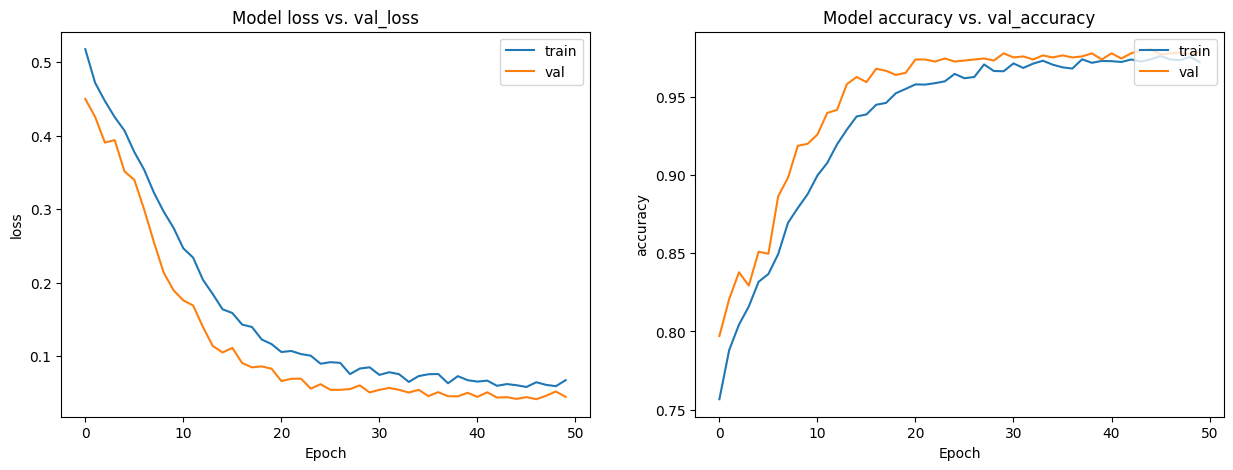

In [46]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, metrics):
    fig, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
    for i, metric in enumerate(metrics):
        axs[i].plot(history.history[metric[0]])
        axs[i].plot(history.history[metric[1]])
        axs[i].set_title('Model ' + metric[0] + ' vs. ' + metric[1])
        axs[i].set_ylabel(metric[0])
        axs[i].set_xlabel('Epoch')
        axs[i].legend(['train', 'val'], loc='upper right')
    plt.show()
    
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])


We can see that we are still converging to an optimum and have done a sufficient job in preventing overfitting to the training set. Let's use the final model to predict the true test set and submit to kaggle.

In [59]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('model.h5')

# Make predictions on the test set using the best model
y_pred_prob = best_model.predict(test_padded_sentences)

# Convert predicted probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype('int32')

# Adding the predictions to the submission file and outputting
sample_sub["target"] = y_pred
sample_sub.to_csv("nlp-getting-started/final_submission.csv", index=False)

102/102 [==============================] - 1s 7ms/step


## Conclusion

We have created predictions for the Kaggle competition on disaster tweets. When uploading these predictions to the Kaggle website, we got to the following scores:

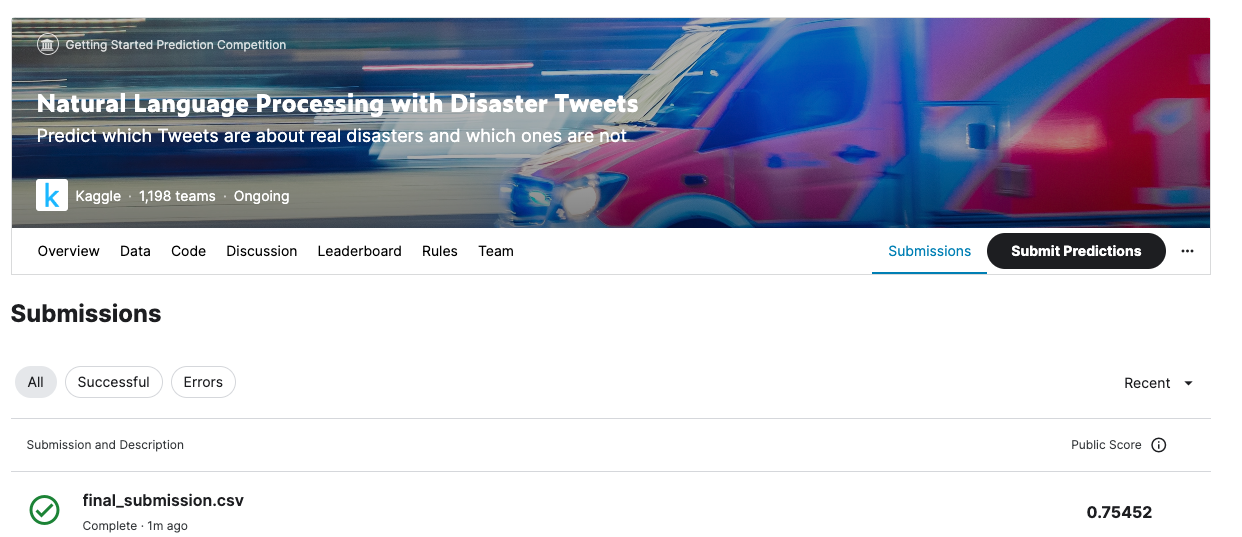

Overall, we were able to create a fair LSTM model to predict the content of the tweets (real disaster/fake disaster) and got a pretty good public score at the first try. When further optimizing the model, there are many steps we can take additionally. We could change batch sizing, optimizers, activation functions, learning rates, and further tweek the epochs and LSTM units. Interestingly, at the moment, adding additional layers beyond 2 did not improve the performance. That could be just due to chance and may in fact work after all in future versions. We could also take a more data-centric approach and try and fine-tune the pre-trained word embedings. We could play around with other language models, in particular with BERT and GPT, which have gotten a lot of attention lately. 

As a take-away, I would like to recognize that it was fairly easy to set up this pipeline for training a text-based model using the existing libraries.

### GitHub Repo: https://github.com/michielschinkel/Deep-Learning